In [1]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 52.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 43.2 MB/s eta 0:00:00


In [2]:
import os, json, h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cpu


In [3]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_dataset"
DATASET = "ashkhagan/figshare-brain-tumor-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)


Dataset URL: https://www.kaggle.com/datasets/ashkhagan/figshare-brain-tumor-dataset


In [4]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))

paths, labels = [], []

for f in mat_files:
    with h5py.File(f, "r") as mat:
        if "label" in mat:
            label = int(mat["label"][()][0][0])
        else:
            label = int(mat["cjdata"]["label"][()][0][0])
    paths.append(f)
    labels.append(label - 1)

df = pd.DataFrame({"image_path": paths, "label": labels})
num_classes = df["label"].nunique()

train_df, test_df = train_test_split(df, stratify=df.label, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(train_df, stratify=train_df.label, test_size=0.2, random_state=42)


In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        with h5py.File(path, "r") as mat:
            if "image" in mat:
                img = mat["image"][()]
            else:
                img = mat["cjdata"]["image"][()]

        img = np.array(img).T
        img = np.stack([img]*3, axis=-1).astype(np.uint8)
        img = self.transform(img)

        return img, label


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [7]:
model = timm.create_model(
    "mobilenetv2_100",
    pretrained=True,
    num_classes=num_classes
)

model = model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=EPOCHS
)


In [9]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []
    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [10]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader,
                desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]")

    for x,y in pbar:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()

        outputs = model(x)

        # Handle tuple (Inception safety)
        if isinstance(outputs, tuple):
            main_out, aux_out = outputs
            loss = criterion(main_out, y) + 0.4 * criterion(aux_out, y)
            out = main_out
        else:
            loss = criterion(outputs, y)
            out = outputs

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        preds = out.argmax(1)
        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out, y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(
        train_targets, train_preds
    )

    train_out = {k:v.compute().item() for k,v in train_metrics.items()}

    print(f"\n[TRAIN] loss: {train_loss:.4f}, "
          f"accuracy: {train_out['acc']:.4f}, "
          f"precision: {train_out['precision']:.4f}, "
          f"recall: {train_out['recall']:.4f}, "
          f"f1_score: {train_out['f1']:.4f}, "
          f"specificity: {train_spec:.4f}, "
          f"sensitivity: {train_sens:.4f}, "
          f"mcc: {train_out['mcc']:.4f}, "
          f"auc: {train_out['auc']:.4f}")

    # ===== STORE TRAIN HISTORY =====
    history["loss"].append(train_loss)
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)
    history["mcc"].append(train_out["mcc"])
    history["auc"].append(train_out["auc"])

    for m in train_metrics.values():
        m.reset()

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    pbar = tqdm(val_loader, desc="Validating Model")

    with torch.no_grad():
        for x,y in pbar:
            x,y = x.to(device), y.to(device)

            outputs = model(x)

            if isinstance(outputs, tuple):
                outputs = outputs[0]

            loss = criterion(outputs, y)
            val_loss += loss.item()

            preds = outputs.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(outputs, y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(
        val_targets, val_preds
    )

    val_out = {k:v.compute().item() for k,v in val_metrics.items()}

    print(f"[VAL]   loss: {val_loss:.4f}, "
          f"accuracy: {val_out['acc']:.4f}, "
          f"precision: {val_out['precision']:.4f}, "
          f"recall: {val_out['recall']:.4f}, "
          f"f1_score: {val_out['f1']:.4f}, "
          f"specificity: {val_spec:.4f}, "
          f"sensitivity: {val_sens:.4f}, "
          f"mcc: {val_out['mcc']:.4f}, "
          f"auc: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    # ===== STORE VAL HISTORY =====
    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)
    history["val_mcc"].append(val_out["mcc"])
    history["val_auc"].append(val_out["auc"])

    scheduler.step()

    for m in val_metrics.values():
        m.reset()

    # ===== EARLY STOPPING =====
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training Model - Epoch [1/30]: 100%|██████████| 245/245 [02:50<00:00,  1.43it/s]



[TRAIN] loss: 0.7852, accuracy: 0.7678, precision: 0.7664, recall: 0.7678, f1_score: 0.7670, specificity: 0.8883, sensitivity: 0.7678, mcc: 0.6608, auc: 0.9101


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


[VAL]   loss: 0.3461, accuracy: 0.8438, precision: 0.8614, recall: 0.8438, f1_score: 0.8510, specificity: 0.9277, sensitivity: 0.8438, mcc: 0.7911, auc: 0.9701
Current LR: 5.000000e-04



Training Model - Epoch [2/30]: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]



[TRAIN] loss: 0.3207, accuracy: 0.8716, precision: 0.8695, recall: 0.8716, f1_score: 0.8705, specificity: 0.9412, sensitivity: 0.8716, mcc: 0.8181, auc: 0.9711


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


[VAL]   loss: 0.2205, accuracy: 0.9178, precision: 0.9001, recall: 0.9178, f1_score: 0.9069, specificity: 0.9583, sensitivity: 0.9178, mcc: 0.8666, auc: 0.9806
Current LR: 4.986305e-04



Training Model - Epoch [3/30]: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]



[TRAIN] loss: 0.1751, accuracy: 0.9269, precision: 0.9257, recall: 0.9269, f1_score: 0.9263, specificity: 0.9667, sensitivity: 0.9269, mcc: 0.8969, auc: 0.9897


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.57it/s]


[VAL]   loss: 0.2186, accuracy: 0.9326, precision: 0.9130, recall: 0.9326, f1_score: 0.9205, specificity: 0.9648, sensitivity: 0.9326, mcc: 0.8858, auc: 0.9848
Current LR: 4.945369e-04



Training Model - Epoch [4/30]: 100%|██████████| 245/245 [02:39<00:00,  1.54it/s]



[TRAIN] loss: 0.1314, accuracy: 0.9498, precision: 0.9449, recall: 0.9498, f1_score: 0.9472, specificity: 0.9766, sensitivity: 0.9498, mcc: 0.9259, auc: 0.9941


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


[VAL]   loss: 0.2776, accuracy: 0.8782, precision: 0.8969, recall: 0.8782, f1_score: 0.8863, specificity: 0.9456, sensitivity: 0.8782, mcc: 0.8430, auc: 0.9789
Current LR: 4.877641e-04



Training Model - Epoch [5/30]: 100%|██████████| 245/245 [02:43<00:00,  1.50it/s]



[TRAIN] loss: 0.0953, accuracy: 0.9619, precision: 0.9603, recall: 0.9619, f1_score: 0.9611, specificity: 0.9822, sensitivity: 0.9619, mcc: 0.9449, auc: 0.9966


Validating Model: 100%|██████████| 62/62 [00:18<00:00,  3.32it/s]


[VAL]   loss: 0.3179, accuracy: 0.9084, precision: 0.8899, recall: 0.9084, f1_score: 0.8965, specificity: 0.9552, sensitivity: 0.9084, mcc: 0.8554, auc: 0.9853
Current LR: 4.783864e-04



Training Model - Epoch [6/30]: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]



[TRAIN] loss: 0.1215, accuracy: 0.9510, precision: 0.9501, recall: 0.9510, f1_score: 0.9505, specificity: 0.9772, sensitivity: 0.9510, mcc: 0.9297, auc: 0.9954


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.56it/s]


[VAL]   loss: 0.1754, accuracy: 0.9199, precision: 0.9213, recall: 0.9199, f1_score: 0.9203, specificity: 0.9630, sensitivity: 0.9199, mcc: 0.8883, auc: 0.9902
Current LR: 4.665064e-04



Training Model - Epoch [7/30]: 100%|██████████| 245/245 [02:44<00:00,  1.49it/s]



[TRAIN] loss: 0.1049, accuracy: 0.9626, precision: 0.9620, recall: 0.9626, f1_score: 0.9623, specificity: 0.9826, sensitivity: 0.9626, mcc: 0.9464, auc: 0.9967


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.54it/s]


[VAL]   loss: 0.2319, accuracy: 0.9391, precision: 0.9245, recall: 0.9391, f1_score: 0.9301, specificity: 0.9692, sensitivity: 0.9391, mcc: 0.9002, auc: 0.9884
Current LR: 4.522542e-04



Training Model - Epoch [8/30]: 100%|██████████| 245/245 [02:45<00:00,  1.48it/s]



[TRAIN] loss: 0.0431, accuracy: 0.9853, precision: 0.9857, recall: 0.9853, f1_score: 0.9855, specificity: 0.9930, sensitivity: 0.9853, mcc: 0.9792, auc: 0.9993


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.50it/s]


[VAL]   loss: 0.2396, accuracy: 0.9273, precision: 0.9210, recall: 0.9273, f1_score: 0.9238, specificity: 0.9656, sensitivity: 0.9273, mcc: 0.8923, auc: 0.9884
Current LR: 4.357862e-04



Training Model - Epoch [9/30]: 100%|██████████| 245/245 [02:40<00:00,  1.52it/s]



[TRAIN] loss: 0.0624, accuracy: 0.9770, precision: 0.9761, recall: 0.9770, f1_score: 0.9765, specificity: 0.9895, sensitivity: 0.9770, mcc: 0.9672, auc: 0.9986


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.47it/s]


[VAL]   loss: 0.1859, accuracy: 0.9442, precision: 0.9371, recall: 0.9442, f1_score: 0.9405, specificity: 0.9726, sensitivity: 0.9442, mcc: 0.9144, auc: 0.9901
Current LR: 4.172827e-04



Training Model - Epoch [10/30]: 100%|██████████| 245/245 [02:41<00:00,  1.52it/s]



[TRAIN] loss: 0.0688, accuracy: 0.9776, precision: 0.9773, recall: 0.9776, f1_score: 0.9774, specificity: 0.9895, sensitivity: 0.9776, mcc: 0.9680, auc: 0.9981


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.52it/s]


[VAL]   loss: 0.2584, accuracy: 0.9502, precision: 0.9308, recall: 0.9502, f1_score: 0.9379, specificity: 0.9730, sensitivity: 0.9502, mcc: 0.9110, auc: 0.9878
Current LR: 3.969463e-04



Training Model - Epoch [11/30]: 100%|██████████| 245/245 [02:42<00:00,  1.50it/s]



[TRAIN] loss: 0.0216, accuracy: 0.9939, precision: 0.9927, recall: 0.9939, f1_score: 0.9933, specificity: 0.9966, sensitivity: 0.9939, mcc: 0.9896, auc: 0.9999


Validating Model: 100%|██████████| 62/62 [00:17<00:00,  3.46it/s]

[VAL]   loss: 0.2433, accuracy: 0.9301, precision: 0.9360, recall: 0.9301, f1_score: 0.9329, specificity: 0.9671, sensitivity: 0.9301, mcc: 0.9039, auc: 0.9881
Current LR: 3.750000e-04

Early stopping triggered.


In [11]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds, all_targets = [], []
test_loss = 0

with torch.no_grad():
    for x,y in tqdm(test_loader, desc="Testing"):
        x,y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out,y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

test_loss /= len(test_loader)

print("\nTest Loss:", test_loss)


Testing: 100%|██████████| 77/77 [00:21<00:00,  3.56it/s]


Test Loss: 0.1965534012588959


In [12]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print(classification_report(all_targets, all_preds, digits=4))


              precision    recall  f1-score   support

           0     0.8707    0.9014    0.8858       142
           1     0.9600    0.9263    0.9429       285
           2     0.9529    0.9785    0.9655       186

    accuracy                         0.9364       613
   macro avg     0.9279    0.9354    0.9314       613
weighted avg     0.9372    0.9364    0.9365       613



In [13]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 77/77 [00:21<00:00,  3.51it/s]



===== TEST RESULTS =====
Test Loss: 0.1966
ACC: 0.9354
PRECISION: 0.9279
RECALL: 0.9354
F1: 0.9314
AUC: 0.9888
MCC: 0.9011


In [14]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.8707    0.9014    0.8858       142
           1     0.9600    0.9263    0.9429       285
           2     0.9529    0.9785    0.9655       186

    accuracy                         0.9364       613
   macro avg     0.9279    0.9354    0.9314       613
weighted avg     0.9372    0.9364    0.9365       613



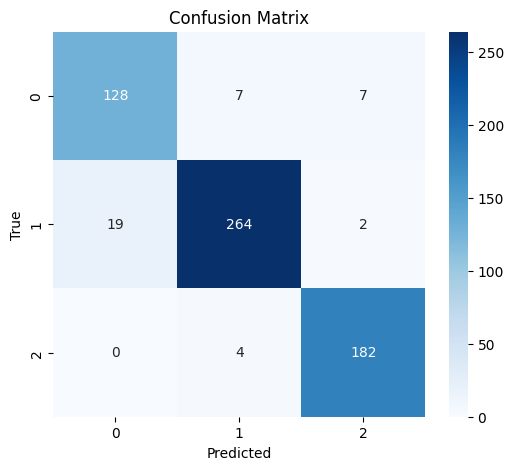

In [15]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [17]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


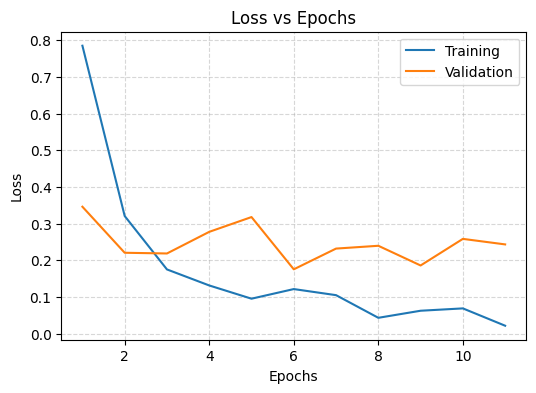

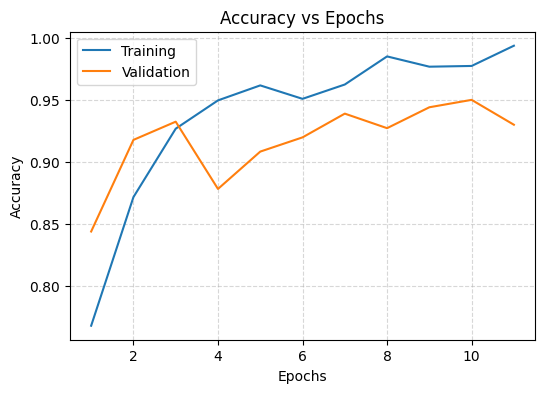

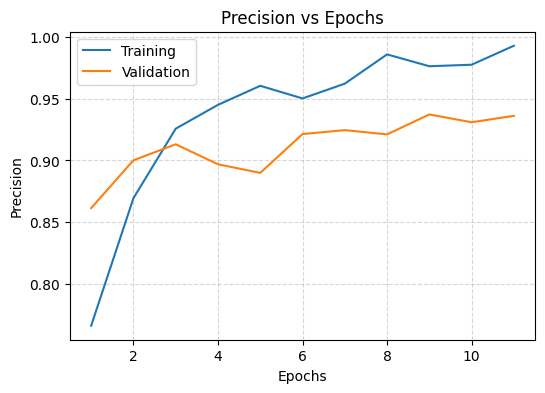

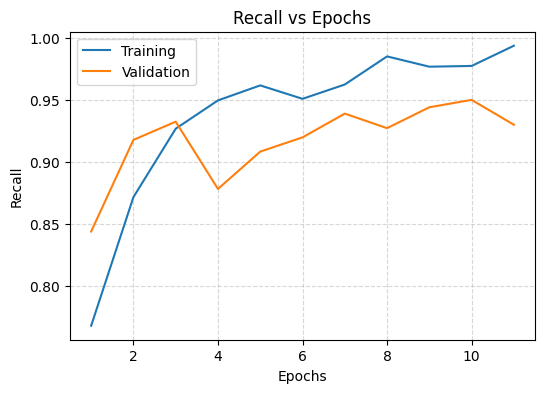

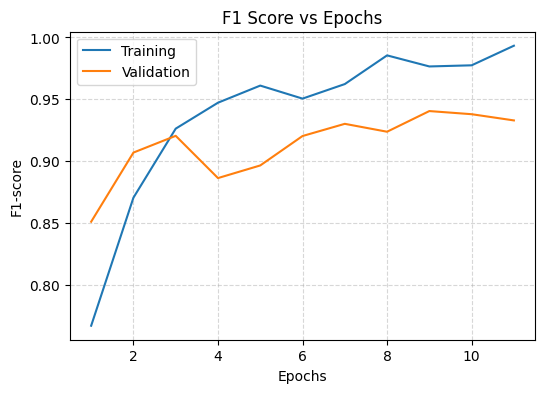

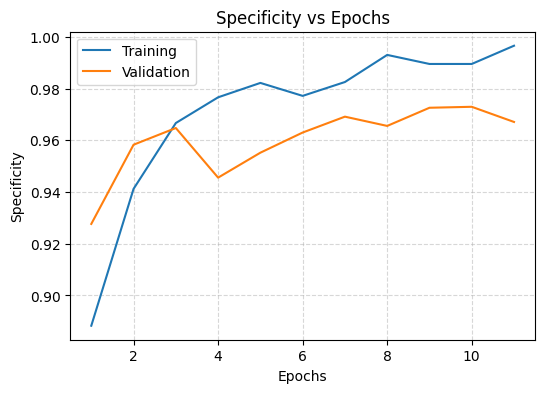

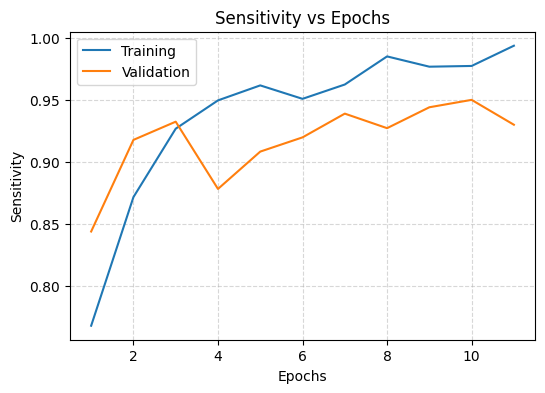

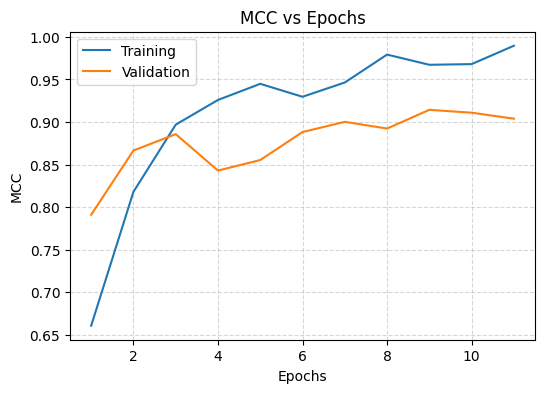

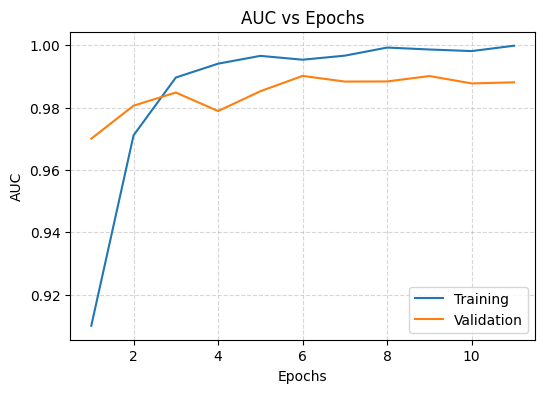

In [18]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
